# this notebook is for evaluation of autoML thyroid report model

### import libraries

In [22]:
import pandas as pd
import os
from collections import Counter
import numpy as np
from google.cloud import automl
from functools import partial
import sklearn
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

### reload predictions

In [2]:
preds = pd.read_csv('test_predictions.csv')
preds.head()

,single,multiple,predictions_0.5,predictions_0.55,predictions_0.6,predictions_0.65,predictions_0.7,predictions_0.75,predictions_0.8,predictions_0.85,predictions_0.9,predictions_0.95
0,0.990787,0.009213,1,1,1,1,1,1,1,1,1,1
1,0.990224,0.009776,1,1,1,1,1,1,1,1,1,1
2,0.996347,0.003653,1,1,1,1,1,1,1,1,1,1
3,0.450748,0.549252,>1,>1,>1,>1,>1,>1,>1,>1,>1,>1
4,0.997189,0.002812,1,1,1,1,1,1,1,1,1,1


### load labelled test set

In [3]:
test_df = pd.read_csv('thyroid_test_data.csv')
test_df.head()

,Accession,MRN,Sign off Rad,Exam Result,Date,labels
0,16851023.0,N000861996,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1
1,16851107.0,N000444488,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1
2,16851388.0,N000923373,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1
3,16854532.0,N000935827,CARVALHO,FINE-NEEDLE ASPIRATION THYROID NODULE\r\n\r\nP...,2021-02-24,2
4,16854824.0,N000504684,CARVALHO,FINE-NEEDLE ASPIRATION THYROID NODULE\r\n\r\nP...,2021-02-24,1


In [4]:
combo = pd.merge(test_df, preds, left_index = True, right_index = True)

In [5]:
combo.head()

,Accession,MRN,Sign off Rad,Exam Result,Date,labels,single,multiple,predictions_0.5,predictions_0.55,predictions_0.6,predictions_0.65,predictions_0.7,predictions_0.75,predictions_0.8,predictions_0.85,predictions_0.9,predictions_0.95
0,16851023.0,N000861996,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1,0.990787,0.009213,1,1,1,1,1,1,1,1,1,1
1,16851107.0,N000444488,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1,0.990224,0.009776,1,1,1,1,1,1,1,1,1,1
2,16851388.0,N000923373,FITZGERALD,FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request ...,2021-02-23,1,0.996347,0.003653,1,1,1,1,1,1,1,1,1,1
3,16854532.0,N000935827,CARVALHO,FINE-NEEDLE ASPIRATION THYROID NODULE\r\n\r\nP...,2021-02-24,2,0.450748,0.549252,>1,>1,>1,>1,>1,>1,>1,>1,>1,>1
4,16854824.0,N000504684,CARVALHO,FINE-NEEDLE ASPIRATION THYROID NODULE\r\n\r\nP...,2021-02-24,1,0.997189,0.002812,1,1,1,1,1,1,1,1,1,1


In [6]:
Counter(combo.labels)

Counter({'1': 42, '2': 4, nan: 1, '>2': 1})

In [7]:
#I know from previously checking that the nan value is from a breast aspiration
combo = combo.dropna()
combo.labels.replace({'2': '>1', '>2': '>1'}, inplace = True)
Counter(combo.labels)

Counter({'1': 42, '>1': 5})

In [8]:
accs = []
for col in combo.columns[8:]:
    thresh =  col[12:]
    acc = (combo.labels == combo[col]).mean()
    accs.append((f'threshold: {thresh}', f'accuracy: {acc}'))
    
accs

[('threshold: 0.5', 'accuracy: 0.9574468085106383'),
 ('threshold: 0.55', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.6', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.65', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.7', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.75', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.8', 'accuracy: 0.9787234042553191'),
 ('threshold: 0.85', 'accuracy: 0.9574468085106383'),
 ('threshold: 0.9', 'accuracy: 0.9361702127659575'),
 ('threshold: 0.95', 'accuracy: 0.851063829787234')]

In [31]:
def get_metrics(preds,predictions, true_vals, thresh, update_results = False, print_confusion = True):
    
    ''' A function to measure a suite of metrics on model classification of thyroid reports
         - here preds is the predicted class, predictions is the probability array
    '''

    f1_w = sklearn.metrics.f1_score(true_vals, preds, average='weighted')
    f1 = sklearn.metrics.f1_score(true_vals, preds, average=None)
    acc = sklearn.metrics.accuracy_score(true_vals, preds)
    prec = sklearn.metrics.precision_score(true_vals,preds, average=None) 
    rec = sklearn.metrics.recall_score(true_vals,preds, average=None)
    auroc = sklearn.metrics.roc_auc_score(true_vals,predictions[:,1])
    confusion = sklearn.metrics.confusion_matrix(true_vals, preds)

    tn, fn, fp, tp = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)

    print (f'Metrics Report for threshold {thresh}:')
    print ('---------------')
    print ('weighted f1: ', f1_w)
    print ('AUROC:       ',auroc)
    print ('accuracy:    ', acc)
    print ('precision:   ', prec)
    print ('recall:      ', rec)
    print ('sensitivity: ', sens)
    print ('specificity: ', spec)
    print ('PPV:         ', ppv)
    print ('NPV:         ', npv)
    print ()
    
    if print_confusion:
        sns.heatmap(confusion,
            annot = True,fmt = '',
            cmap = 'Blues',
            cbar = False,
            xticklabels = ['1', '>1'],
            yticklabels = ['1', '>1'] )
        plt.xlabel('actual')
        plt.ylabel('predicted')
        plt.title('multiple biopsy predictions confusion matrix')
        plt.show()

    if update_results == True:
        results_df.loc[len(results_df)] = [desc,num_samples, weights, f1_w, acc, auroc, ppv, sens, batch_size]

In [12]:
preds = np.array(list(zip(combo['single'], combo['multiple'])))

In [13]:
preds.shape

(47, 2)

In [14]:
preds[:10]

array([[9.90787089e-01, 9.21288133e-03],
       [9.90224302e-01, 9.77574941e-03],
       [9.96346772e-01, 3.65327834e-03],
       [4.50747699e-01, 5.49252331e-01],
       [9.97188509e-01, 2.81153386e-03],
       [9.99632478e-01, 3.67504923e-04],
       [9.96367693e-01, 3.63229006e-03],
       [8.97350848e-01, 1.02649160e-01],
       [9.93884981e-01, 6.11501839e-03],
       [9.93884981e-01, 6.11501839e-03]])

Metrics Report:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



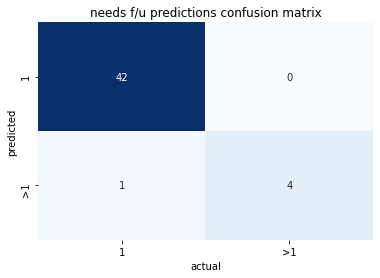

In [23]:
get_metrics(combo['predictions_0.55'],preds,  combo.labels)

Metrics Report for threshold 0.5:
---------------
weighted f1:  0.95262246412667
AUROC:        0.8095238095238095
accuracy:     0.9574468085106383
precision:    [0.95454545 1.        ]
recall:       [1.  0.6]
sensitivity:  1.0
specificity:  0.9545454545454546
PPV:          0.6
NPV:          1.0



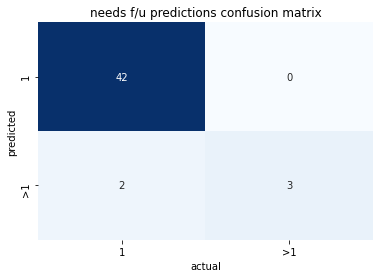

Metrics Report for threshold 0.55:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



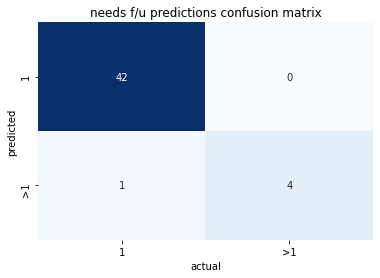

Metrics Report for threshold 0.6:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



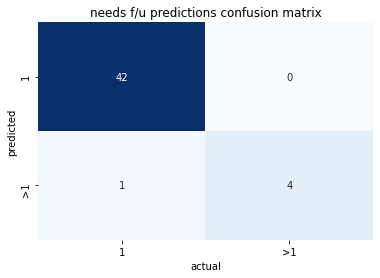

Metrics Report for threshold 0.65:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



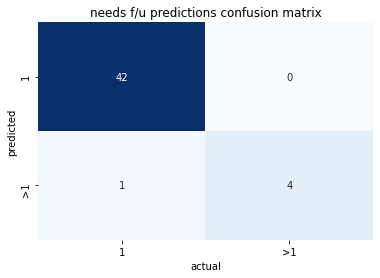

Metrics Report for threshold 0.7:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



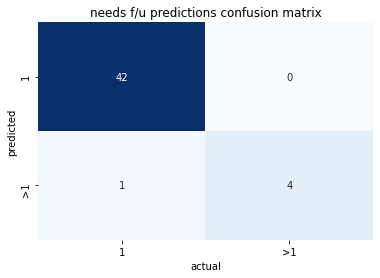

Metrics Report for threshold 0.75:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



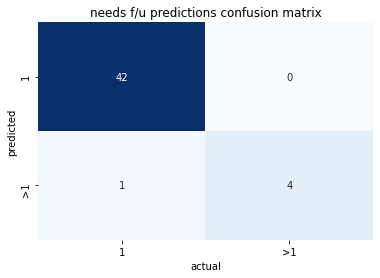

Metrics Report for threshold 0.8:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



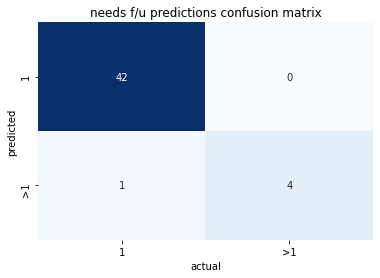

Metrics Report for threshold 0.85:
---------------
weighted f1:  0.9574468085106383
AUROC:        0.8095238095238095
accuracy:     0.9574468085106383
precision:    [0.97619048 0.8       ]
recall:       [0.97619048 0.8       ]
sensitivity:  0.8
specificity:  0.9761904761904762
PPV:          0.8
NPV:          0.9761904761904762



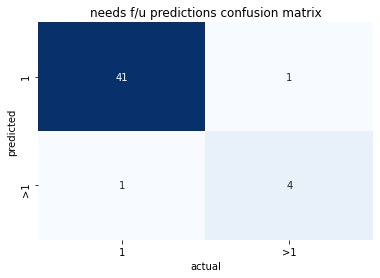

Metrics Report for threshold 0.9:
---------------
weighted f1:  0.9386870499405746
AUROC:        0.8095238095238095
accuracy:     0.9361702127659575
precision:    [0.97560976 0.66666667]
recall:       [0.95238095 0.8       ]
sensitivity:  0.6666666666666666
specificity:  0.975609756097561
PPV:          0.8
NPV:          0.9523809523809523



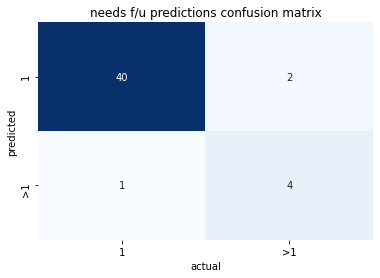

Metrics Report for threshold 0.95:
---------------
weighted f1:  0.8711733548792532
AUROC:        0.8095238095238095
accuracy:     0.851063829787234
precision:    [0.97297297 0.4       ]
recall:       [0.85714286 0.8       ]
sensitivity:  0.4
specificity:  0.972972972972973
PPV:          0.8
NPV:          0.8571428571428571



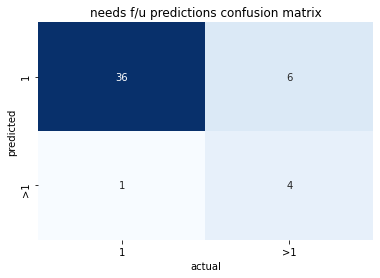

In [29]:
for col in combo.columns[8:]:
    thresh =  col[12:]
    predictions = combo[col]
    get_metrics(predictions,preds, combo.labels, thresh)
    
    #acc = (combo.labels == combo[col]).mean()
    #accs.append((f'threshold: {thresh}', f'accuracy: {acc}'))

In [30]:
Counter(combo.labels), Counter(combo['predictions_0.55'])

(Counter({'1': 42, '>1': 5}), Counter({'1': 43, '>1': 4}))

## best threshold seems to be 0.6

Metrics Report for threshold 0.6:
---------------
weighted f1:  0.9776665276039492
AUROC:        0.8095238095238095
accuracy:     0.9787234042553191
precision:    [0.97674419 1.        ]
recall:       [1.  0.8]
sensitivity:  1.0
specificity:  0.9767441860465116
PPV:          0.8
NPV:          1.0



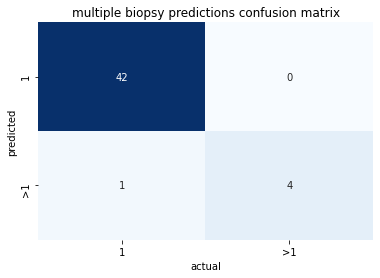

In [33]:
get_metrics(combo['predictions_0.55'],preds, combo.labels, thresh = 0.6)